<a href="https://colab.research.google.com/github/Ouyu-Han/Time-Series-Forecasting/blob/main/Apple_Stock_Price_Forecasting___Ouyu_Han.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Predicting Apple Stock Price**

## Read in the appropriate packages


In [ ]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import yfinance as yf
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series


## 1. Problem Definition

In [ ]:
# Define stock ticker and date range
stock_ticker = 'AAPL'
stock_start_date = datetime.date(2013,12,29)
stock_end_date = datetime.date.today()

# Fetch the stock price from Yahoo Finance using yfinance
stock_df = yf.download(stock_ticker, start=stock_start_date, end=stock_end_date)
stock_df=stock_df[(stock_df.index.year!=2013)]

/tmp/ipython-input-35837096.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_df = yf.download(stock_ticker, start=stock_start_date, end=stock_end_date)
[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2014-01-02,17.156700,17.277669,17.122271,17.235795,234684800
2014-01-03,16.779840,17.174382,16.762780,17.148328,392467600
2014-01-06,16.871344,16.960363,16.550933,16.670351,412610800
2014-01-07,16.750685,16.934307,16.684928,16.883439,317209200
2014-01-08,16.856756,16.921892,16.708803,16.712524,258529600
...,...,...,...,...,...
2026-01-23,248.039993,249.410004,244.679993,247.320007,41689000
2026-01-26,255.410004,256.559998,249.800003,251.479996,55969200


In [ ]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3037 entries, 2014-01-02 to 2026-01-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   3037 non-null   float64
 1   (High, AAPL)    3037 non-null   float64
 2   (Low, AAPL)     3037 non-null   float64
 3   (Open, AAPL)    3037 non-null   float64
 4   (Volume, AAPL)  3037 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 142.4 KB


In [ ]:
stock_df.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2026-01-15', '2026-01-16', '2026-01-20', '2026-01-21',
               '2026-01-22', '2026-01-23', '2026-01-26', '2026-01-27',
               '2026-01-28', '2026-01-29'],
              dtype='datetime64[ns]', name='Date', length=3037, freq=None)

In [ ]:
#handle multiple indexes
stock_df.columns = stock_df.columns.map('_'.join).str.replace(' ','_')


In [ ]:
stock_df

,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
Date,,,,,
2014-01-02,17.156700,17.277669,17.122271,17.235795,234684800
2014-01-03,16.779840,17.174382,16.762780,17.148328,392467600
2014-01-06,16.871344,16.960363,16.550933,16.670351,412610800
2014-01-07,16.750685,16.934307,16.684928,16.883439,317209200
2014-01-08,16.856756,16.921892,16.708803,16.712524,258529600
...,...,...,...,...,...
2026-01-23,248.039993,249.410004,244.679993,247.320007,41689000
2026-01-26,255.410004,256.559998,249.800003,251.479996,55969200
2026-01-27,258.269989,261.950012,258.209991,259.170013,49648300


In [ ]:
stock_df = stock_df[['Close_AAPL']]

In [ ]:
stock_df

,Close_AAPL
Date,
2014-01-02,17.156700
2014-01-03,16.779840
2014-01-06,16.871344
2014-01-07,16.750685
2014-01-08,16.856756
...,...
2026-01-23,248.039993
2026-01-26,255.410004
2026-01-27,258.269989


## 2. EDA

In [ ]:
# 1. Descriptive Statistics
stock_df.describe()

,Close_AAPL
count,3037.000000
mean,100.131604
std,75.834087
min,15.501919
25%,29.045582
50%,65.331215
75%,164.766846
max,286.190002


<Axes: >

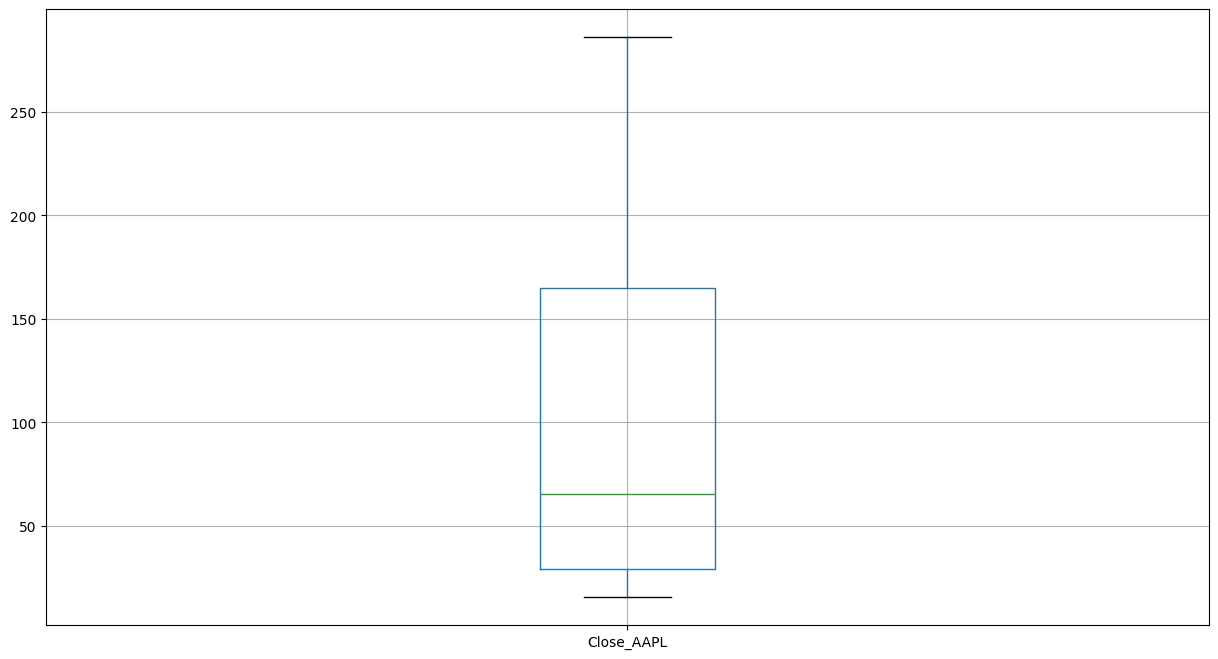

In [ ]:
plt.figure(figsize=(15,8))
stock_df.boxplot()

In [ ]:
# 2. Check for missing values
stock_df.isnull().sum()

,0
Close_AAPL,0


In [ ]:
# 3. Find the indexes that are missing
pd.date_range(start = '2014-01-01', end = stock_end_date).difference(stock_df.index)

DatetimeIndex(['2014-01-01', '2014-01-04', '2014-01-05', '2014-01-11',
               '2014-01-12', '2014-01-18', '2014-01-19', '2014-01-20',
               '2014-01-25', '2014-01-26',
               ...
               '2026-01-03', '2026-01-04', '2026-01-10', '2026-01-11',
               '2026-01-17', '2026-01-18', '2026-01-19', '2026-01-24',
               '2026-01-25', '2026-01-30'],
              dtype='datetime64[ns]', length=1376, freq=None)

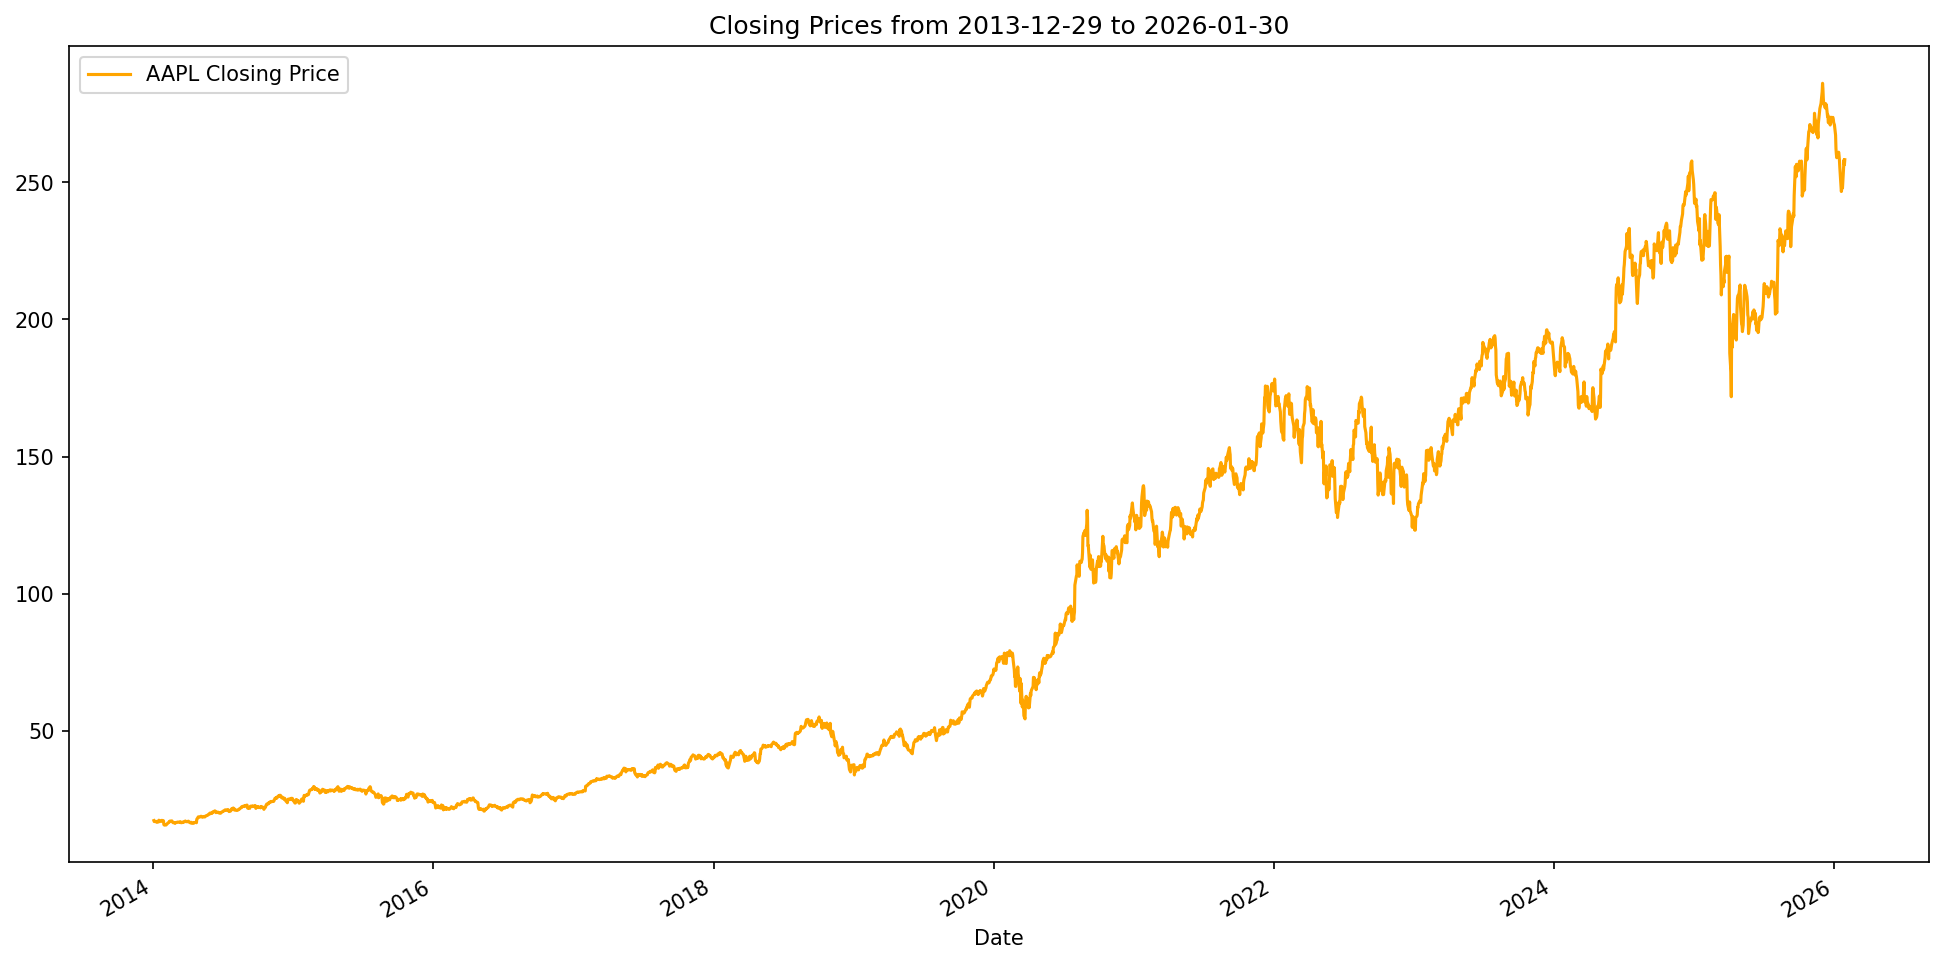

In [ ]:
# Visualizing The Close Price of the stocks

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150) #dpi = resolution. default 100.

# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
stock_df['Close_AAPL'].plot(label='AAPL Closing Price', color='orange')

# adding title to the plot
plt.title('Closing Prices from {} to {}'.format(stock_start_date, stock_end_date))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


**Impute missing values**

In [ ]:
# first, fill the misssing values with 'NaN'. Reindexing.
stock_df_NaN = stock_df.reindex(pd.date_range('2014-01-01', stock_end_date), fill_value= np.nan)
stock_df_NaN

,Close_AAPL,AAPL_Spline
2014-01-01,NaN,NaN
2014-01-02,17.156700,17.156700
2014-01-03,16.779840,16.779840
2014-01-04,NaN,NaN
2014-01-05,NaN,NaN
...,...,...
2026-01-26,255.410004,255.410004
2026-01-27,258.269989,258.269989
2026-01-28,256.440002,256.440002
2026-01-29,258.279999,258.279999


In [ ]:
stock_df_imputed = stock_df_NaN.copy()
stock_df_imputed['AAPL_Spline'] = (stock_df_imputed['Close_AAPL'].interpolate(method='spline', order=1, limit=10, limit_direction='both'))

In [ ]:
stock_df_imputed.round(2)

,Close_AAPL,AAPL_Spline
2014-01-01,NaN,16.68
2014-01-02,17.16,17.16
2014-01-03,16.78,16.78
2014-01-04,NaN,16.67
2014-01-05,NaN,16.67
...,...,...
2026-01-26,255.41,255.41
2026-01-27,258.27,258.27
2026-01-28,256.44,256.44
2026-01-29,258.28,258.28


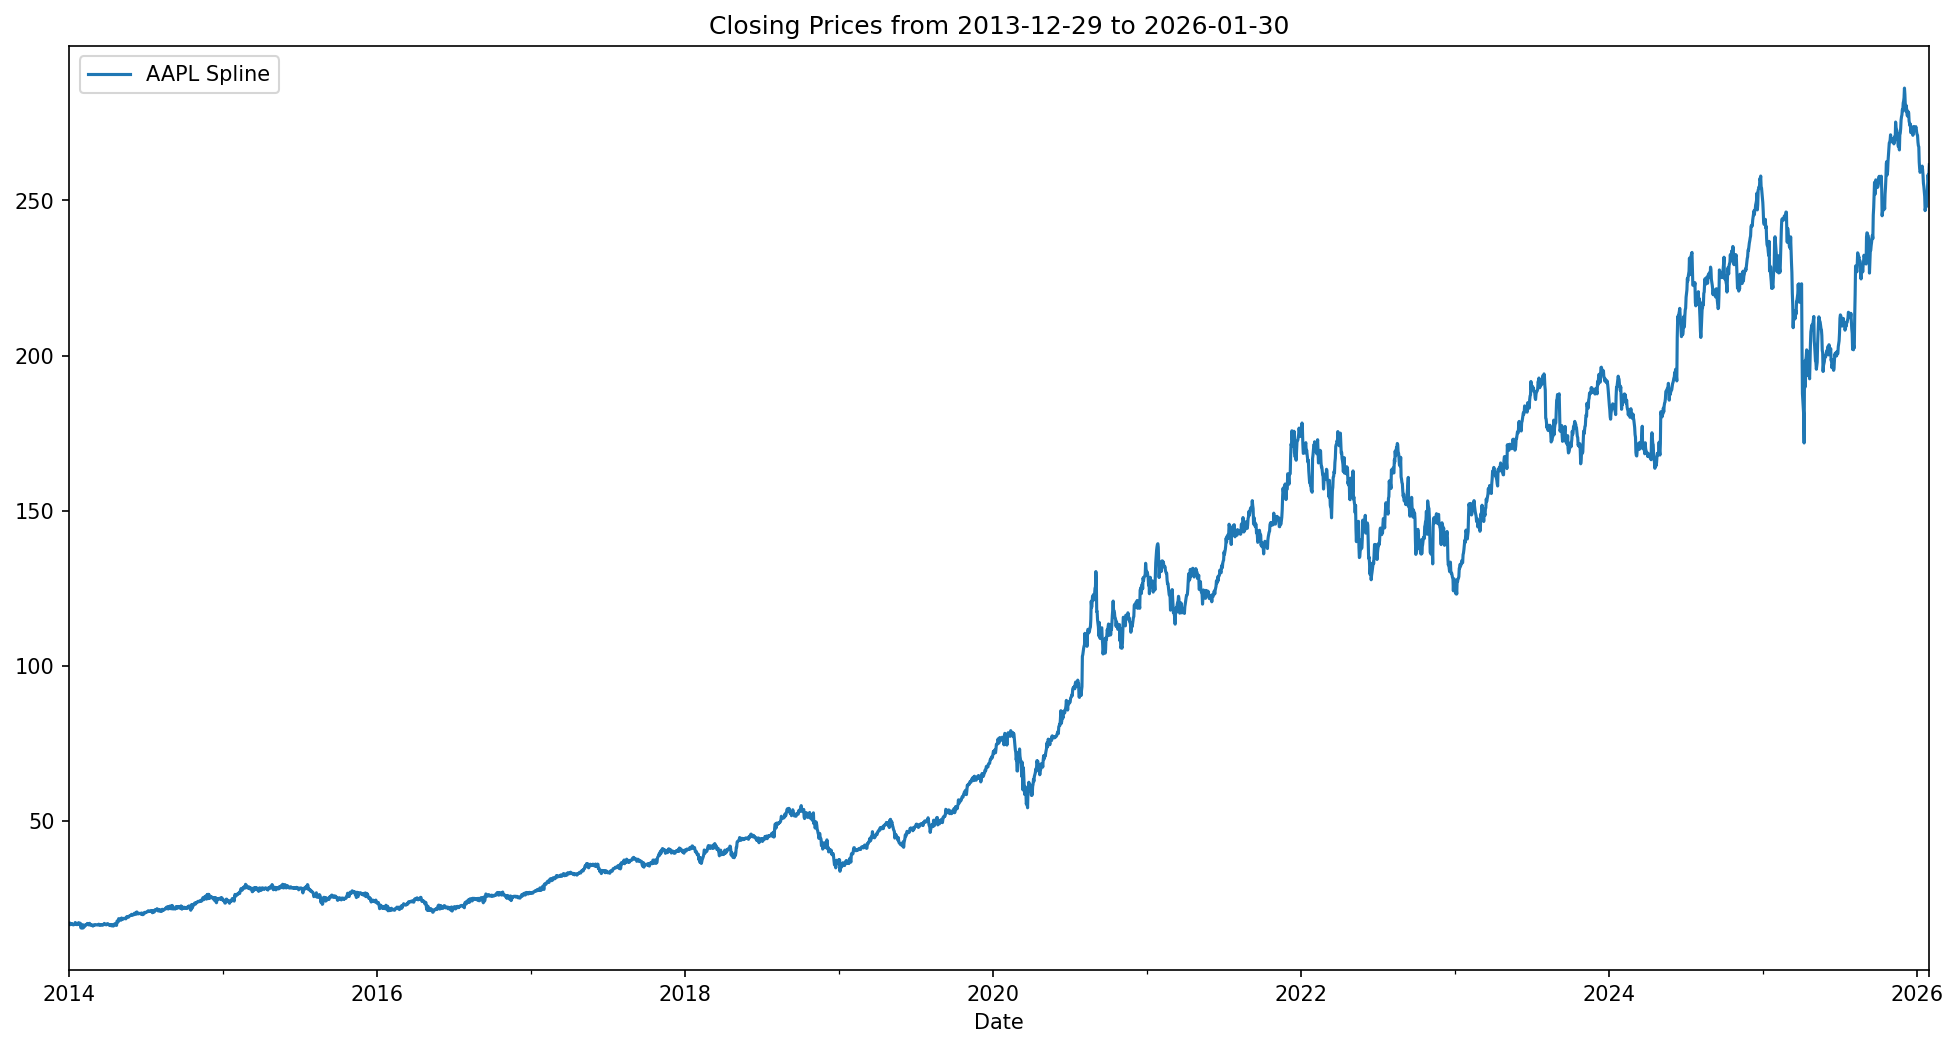

In [ ]:
#Plot

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

stock_df_imputed['AAPL_Spline'].plot(label='AAPL Spline')


# adding title to the plot
plt.title('Closing Prices from {} to {}'.format(stock_start_date, stock_end_date))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()

 **Time Series Visualization**

<Axes: xlabel='None', ylabel='AAPL_Spline'>

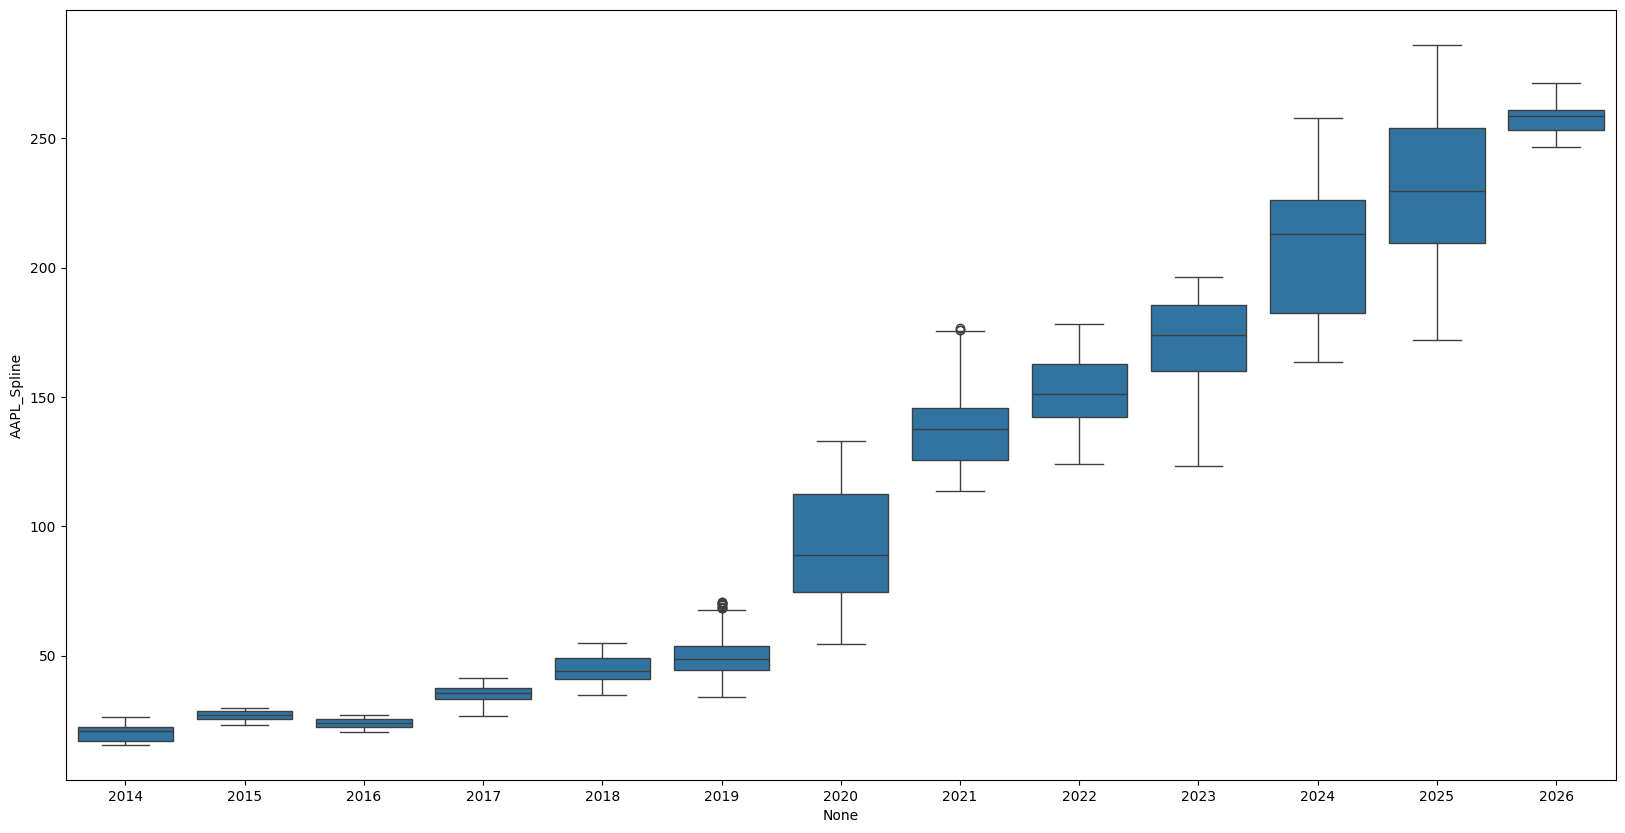

In [ ]:
# price variation for each year

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x = stock_df_imputed.index.year,
                y = stock_df_imputed['AAPL_Spline'],
                ax = ax)

<Axes: xlabel='None', ylabel='AAPL_Spline'>

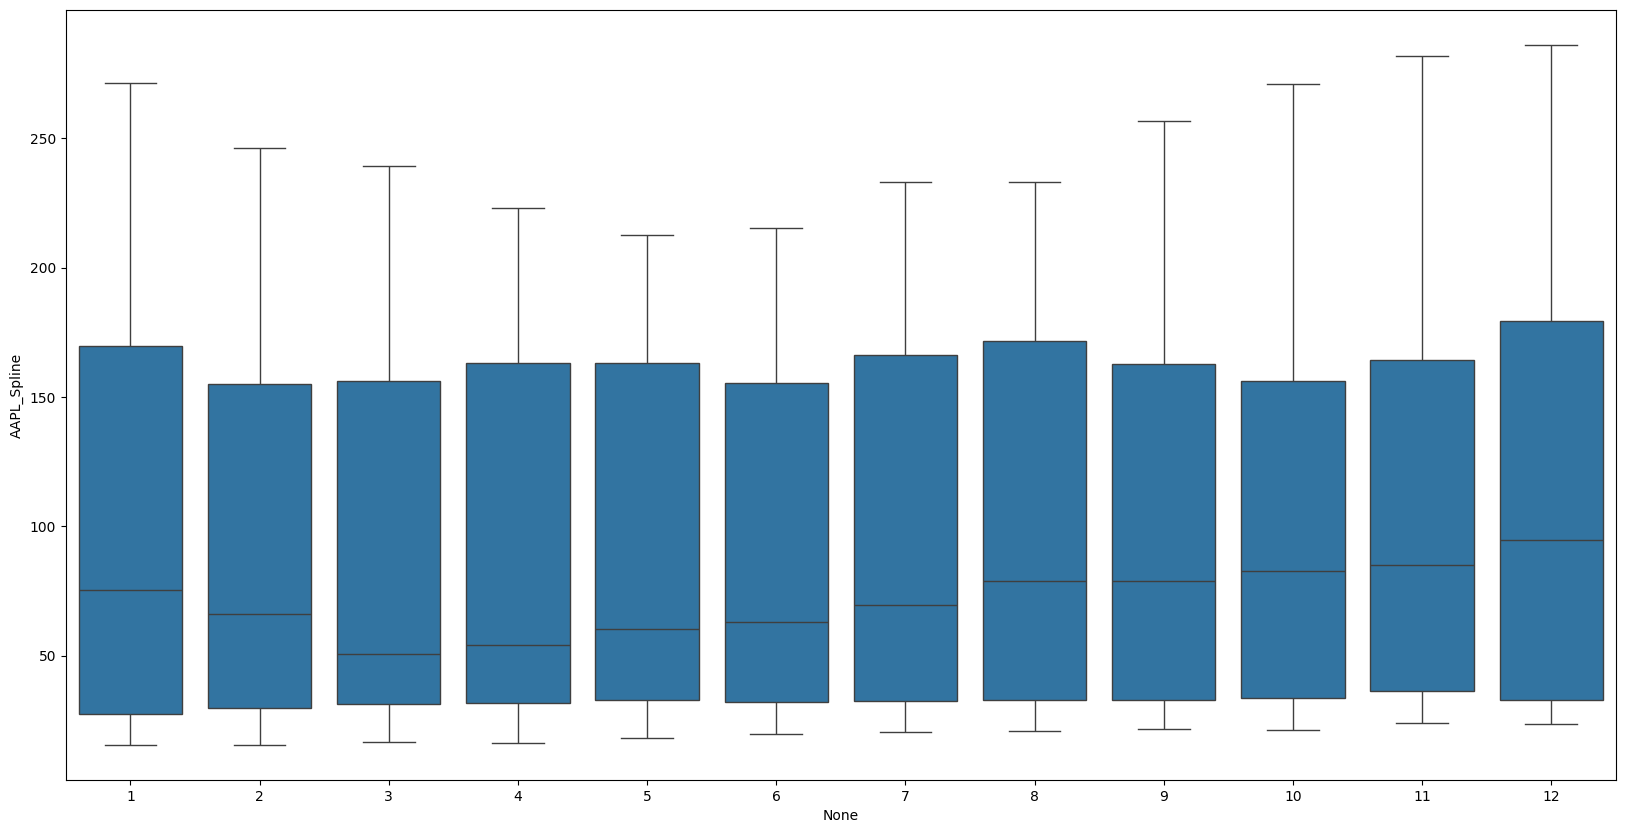

In [ ]:
# price variation for each month

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x = stock_df_imputed.index.month,
                y = stock_df_imputed['AAPL_Spline'],
                ax = ax)

**Resampling**

In [ ]:
df_resample = stock_df_imputed.copy()

# extract only the spline variables
df_resample = df_resample[['AAPL_Spline']].round(2)
df_resample

,AAPL_Spline
2014-01-01,16.68
2014-01-02,17.16
2014-01-03,16.78
2014-01-04,16.67
2014-01-05,16.67
...,...
2026-01-26,255.41
2026-01-27,258.27
2026-01-28,256.44
2026-01-29,258.28


In [ ]:
# downsample the data from days to months to reduce variability in the data
# observe the stock prices on a monthly basis

df_resample_months = df_resample.groupby(pd.Grouper(freq='MS')).median()
#df_resample_months = df_resample.resample('M').median() #another way of resampling
df_resample_months

,AAPL_Spline
2014-01-01,16.670
2014-02-01,16.545
2014-03-01,16.560
2014-04-01,16.610
2014-05-01,18.750
...,...
2025-09-01,238.690
2025-10-01,256.880
2025-11-01,270.765
2025-12-01,274.110


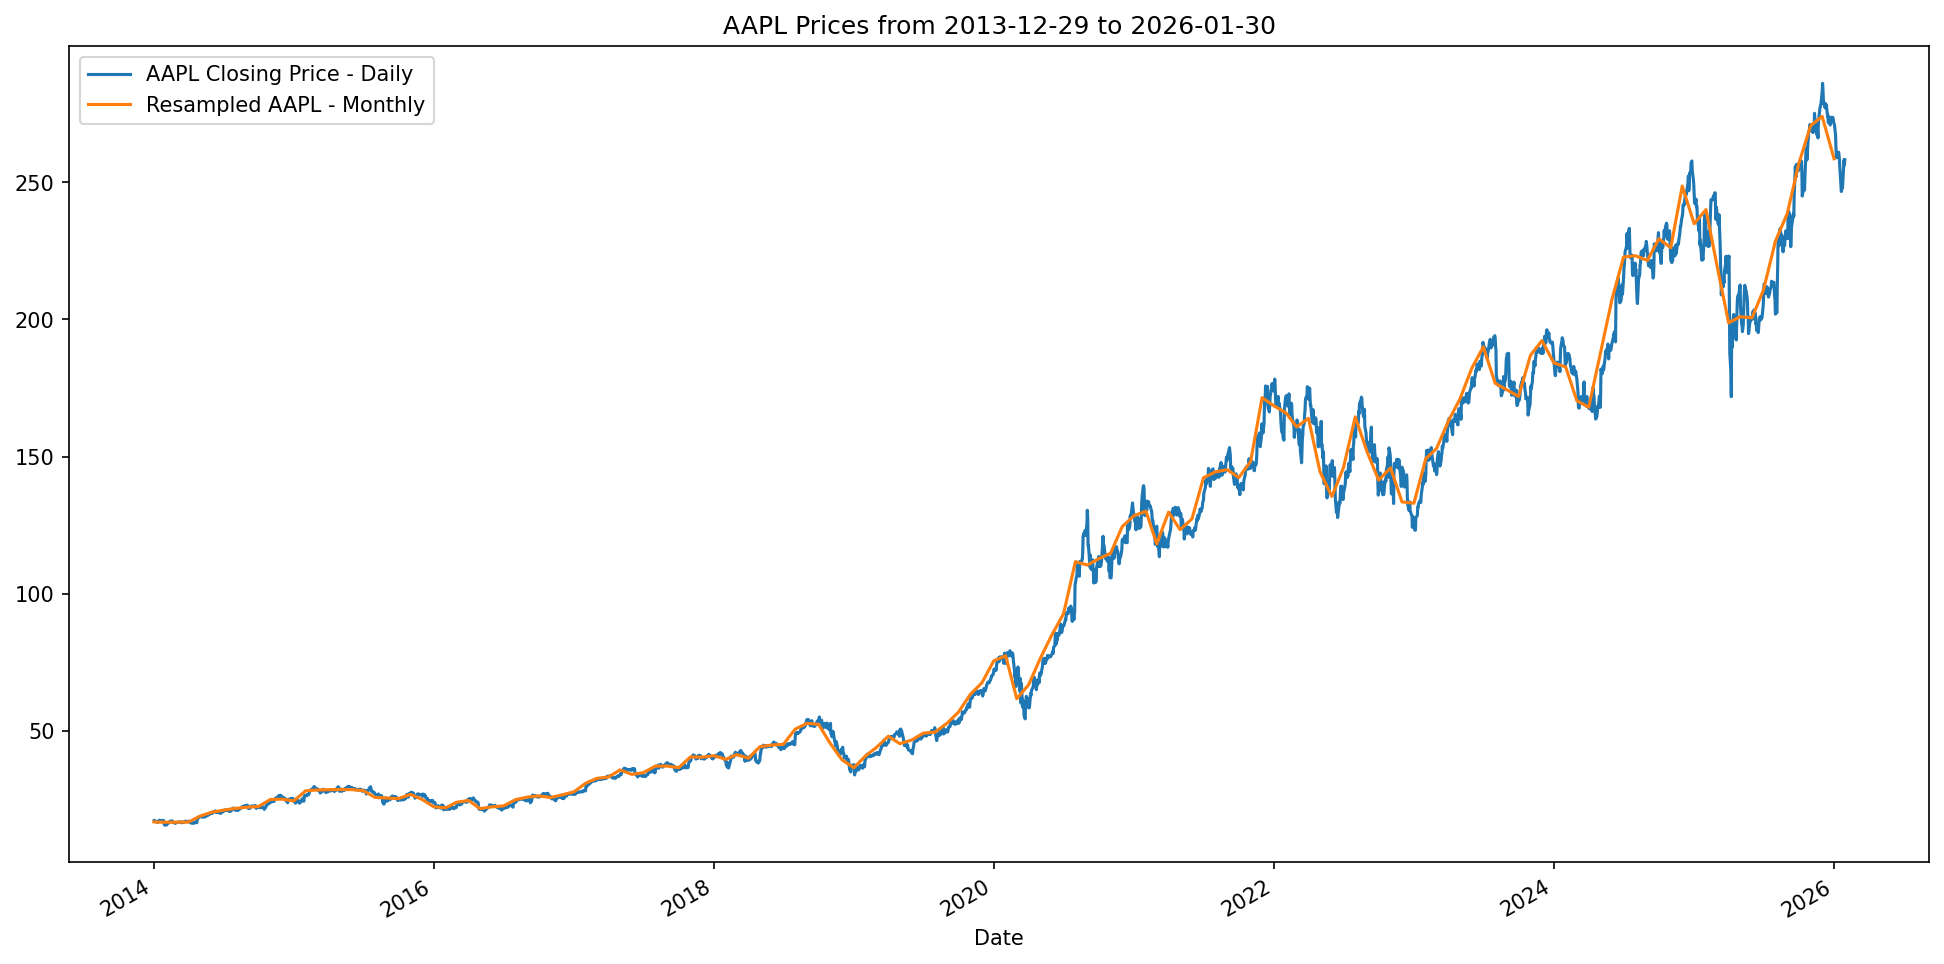

In [ ]:
#Plot monthly data

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
#df_resample_months['MSFT_Spline'].plot(label='MSFT')
stock_df['Close_AAPL'].plot(label='AAPL Closing Price - Daily')
df_resample_months['AAPL_Spline'].plot(label='Resampled AAPL - Monthly')


# adding title to the plot
plt.title('AAPL Prices from {} to {}'.format(stock_start_date, stock_end_date))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()

In [ ]:
# 6. Autocorrelation or ACF plot

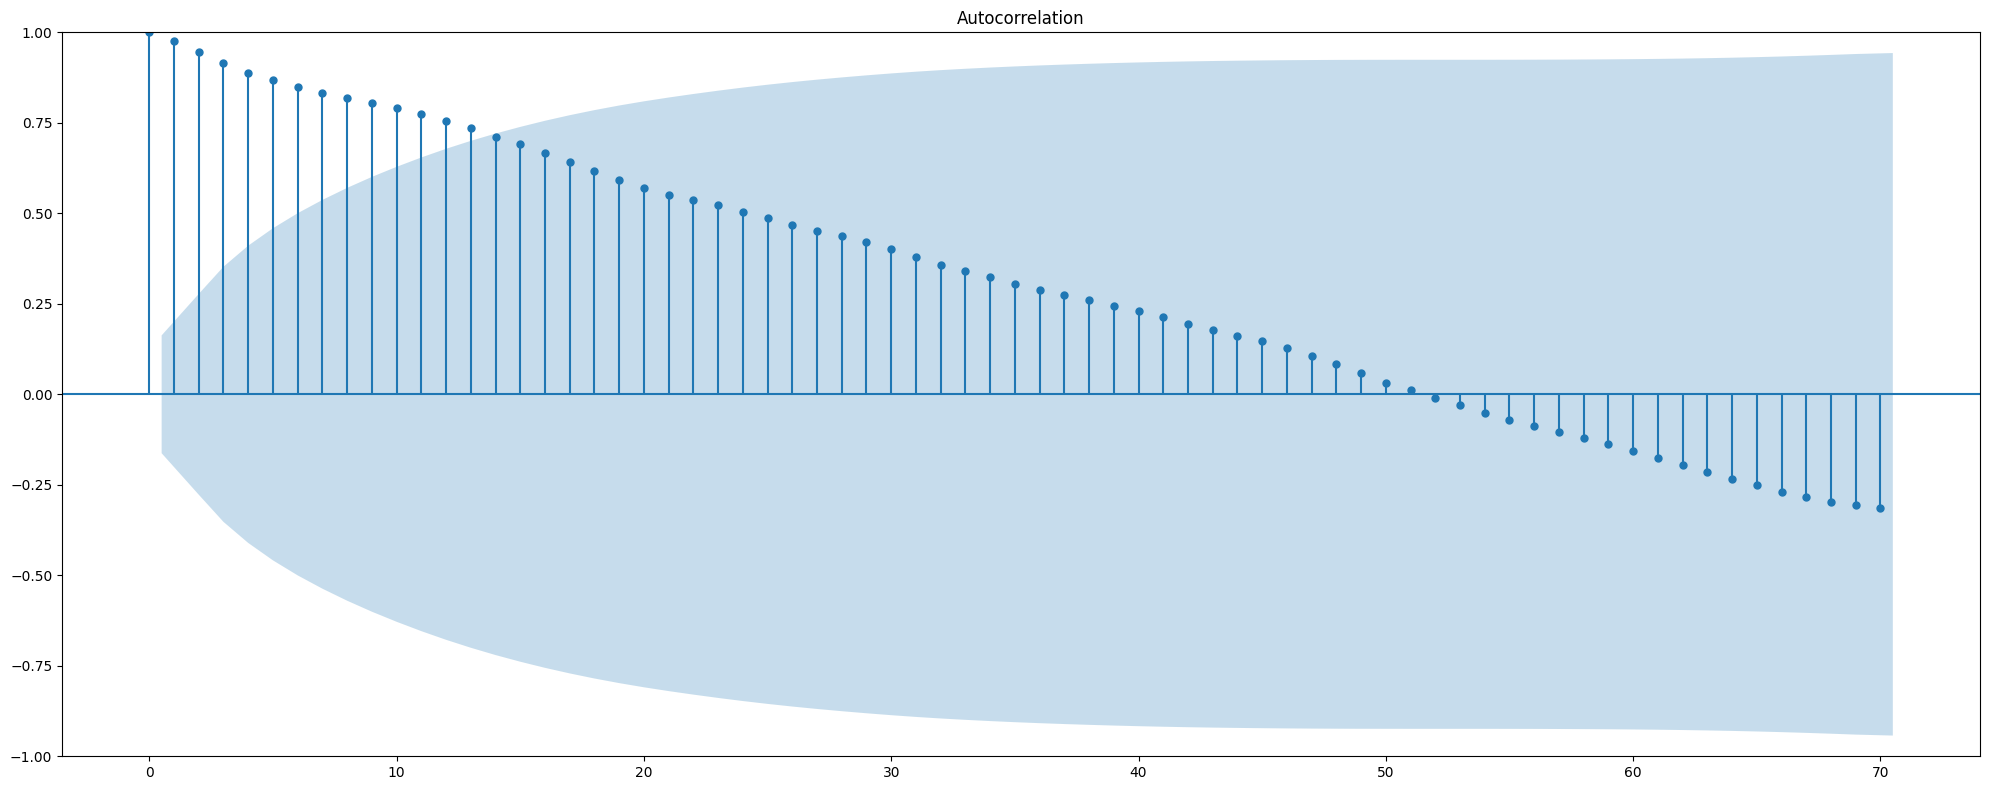

In [ ]:
# Calculate the ACF (via statsmodel)
# Source: https://www.alpharithms.com/autocorrelation-time-series-python-432909/

fig = plot_acf(df_resample_months['AAPL_Spline'], lags=70)
fig.set_size_inches((20, 8))
# Tight layout to realign things
fig.tight_layout()
plt.show()

**7. Time Series Decomposition**

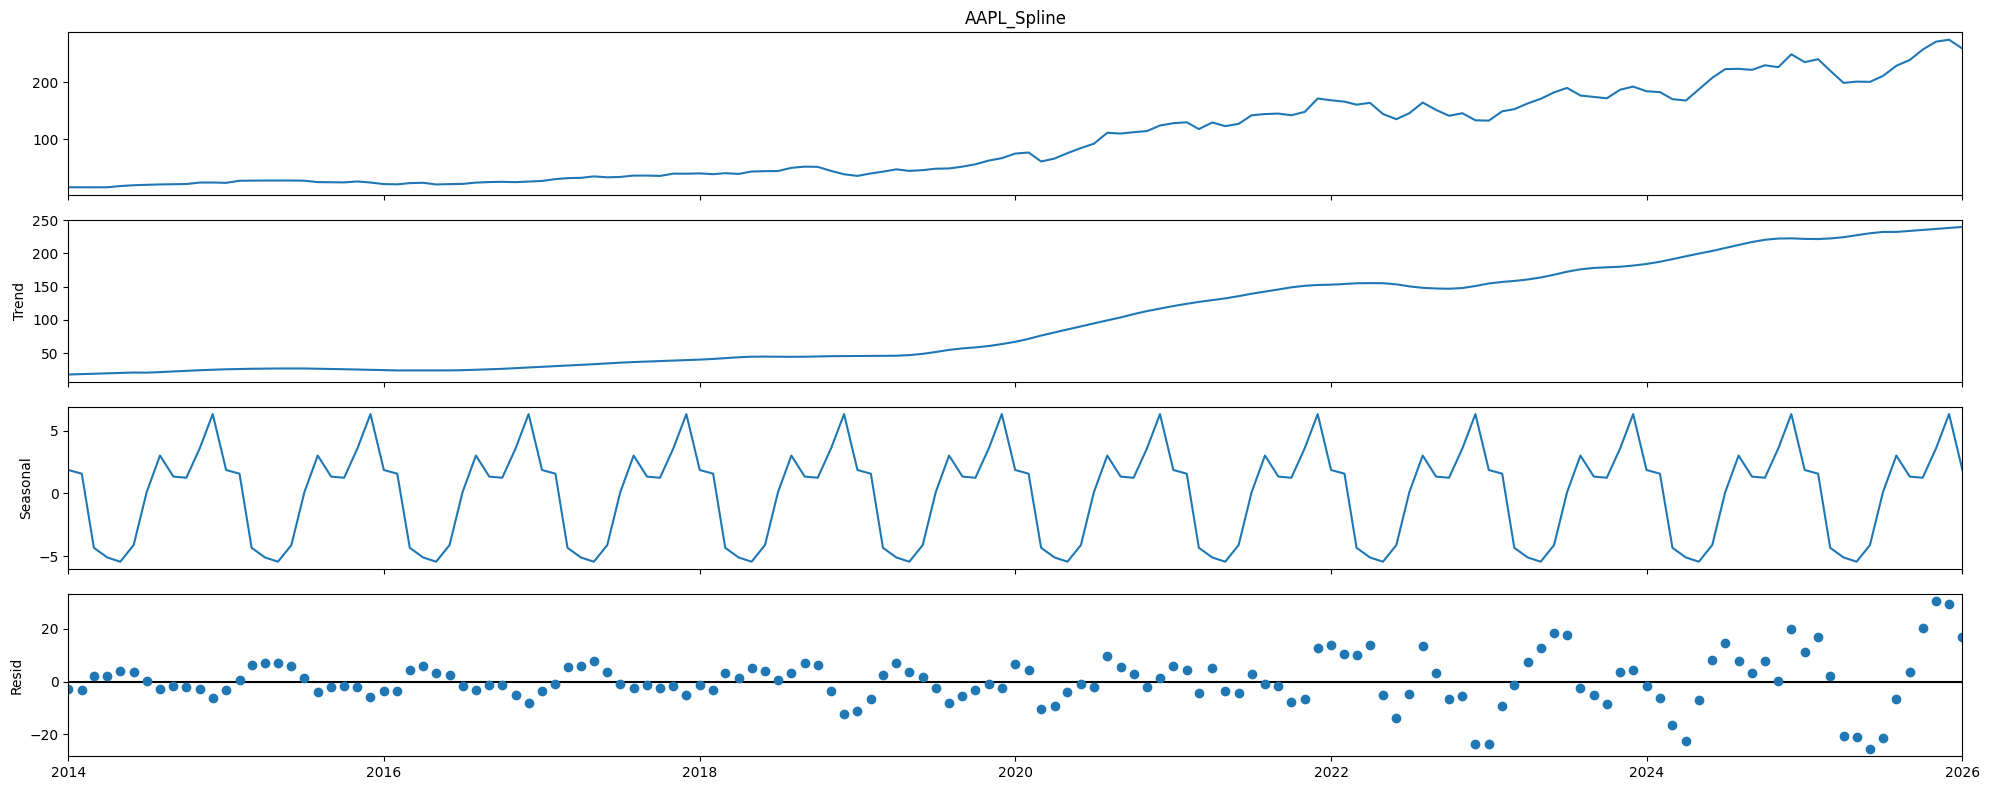

In [ ]:
res = sm.tsa.seasonal_decompose(df_resample_months['AAPL_Spline'], period=12, extrapolate_trend='freq')
fig = res.plot()
fig.set_size_inches((20, 8))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [ ]:
aapl_df = df_resample_months[['AAPL_Spline']]

# extract the decomposed terms
aapl_df['trend'] = res.trend
aapl_df['seasonal'] = res.seasonal
aapl_df['error'] = res.resid
aapl_df

,AAPL_Spline,trend,seasonal,error
2014-01-01,16.670,17.666313,1.858737,-2.855051
2014-02-01,16.545,18.262506,1.565966,-3.283472
2014-03-01,16.560,18.858699,-4.334185,2.035486
2014-04-01,16.610,19.454893,-5.103122,2.258229
2014-05-01,18.750,20.051086,-5.440304,4.139219
...,...,...,...,...
2025-09-01,238.690,233.756098,1.333097,3.600804
2025-10-01,256.880,235.269138,1.243261,20.367601
2025-11-01,270.765,236.782178,3.588945,30.393877
2025-12-01,274.110,238.295218,6.309837,29.504945


<Axes: >

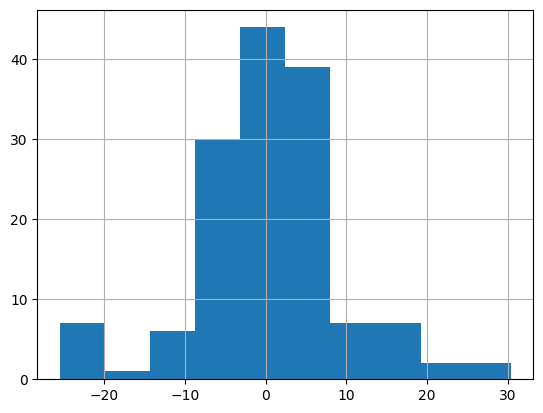

In [ ]:
aapl_df['error'].hist()

## 2. Assess the relaitonship between each of the 3 factors and AAPL

### 3 US economic factors: inflation, unemployment, and interest rate

These three factors capture key dimensions of the broader economic environment that influence firms’ cash flows, discount rates, and investor expectations.

**Inflation** reflects changes in the general price level and directly affects both corporate costs and consumer purchasing power. For firms, higher inflation can increase input and labor costs, potentially compressing profit margins if costs cannot be fully passed on to consumers. At the same time, inflation influences monetary policy decisions, which in turn affect financial markets.

Lower **unemployment** typically signals strong economic activity, rising incomes, and higher consumer spending, which can support corporate revenues, especially for consumer-facing firms. Conversely, rising unemployment suggests weakening demand and economic slowdown, which can negatively affect firm performance and investor sentiment.

**Interest rates** influence the discount rate used to value future cash flows, making equities more or less attractive relative to fixed-income assets. Higher interest rates generally reduce the present value of future earnings and can weigh on stock prices, especially for growth-oriented firms with cash flows concentrated in the future. In addition, interest rates affect borrowing costs, corporate investment decisions, and overall liquidity in financial markets.

Stock price data for AAPL are obtained from Yahoo Finance using adjusted closing prices, while macroeconomic data are sourced from the Federal Reserve Economic Data (FRED) database. All variables are aggregated to a monthly frequency to ensure consistency across data sources.

In [ ]:
start = '2014-01-01'
end = stock_end_date

# Economic factors
cpi = pdr.DataReader('CPIAUCSL', 'fred', start, end)       # Inflation
unrate = pdr.DataReader('UNRATE', 'fred', start, end)    # Unemployment
fedfunds = pdr.DataReader('FEDFUNDS', 'fred', start, end)  # Interest rate

# downsample the data from days to months to reduce variability in the data
cpi_m = cpi.resample('MS').asfreq()
unrate_m = unrate.resample('MS').asfreq()
fedfunds_m = fedfunds.resample('MS').asfreq()

In [ ]:
# to escape the spurious correlation trap
# we should difference the time series to detrend it or make it stationary before we check for correlation.

In [ ]:
differenced = df_resample_months.diff()

In [ ]:
differenced

,AAPL_Spline
2014-01-01,NaN
2014-02-01,-0.125
2014-03-01,0.015
2014-04-01,0.050
2014-05-01,2.140
...,...
2025-09-01,10.110
2025-10-01,18.190
2025-11-01,13.885
2025-12-01,3.345


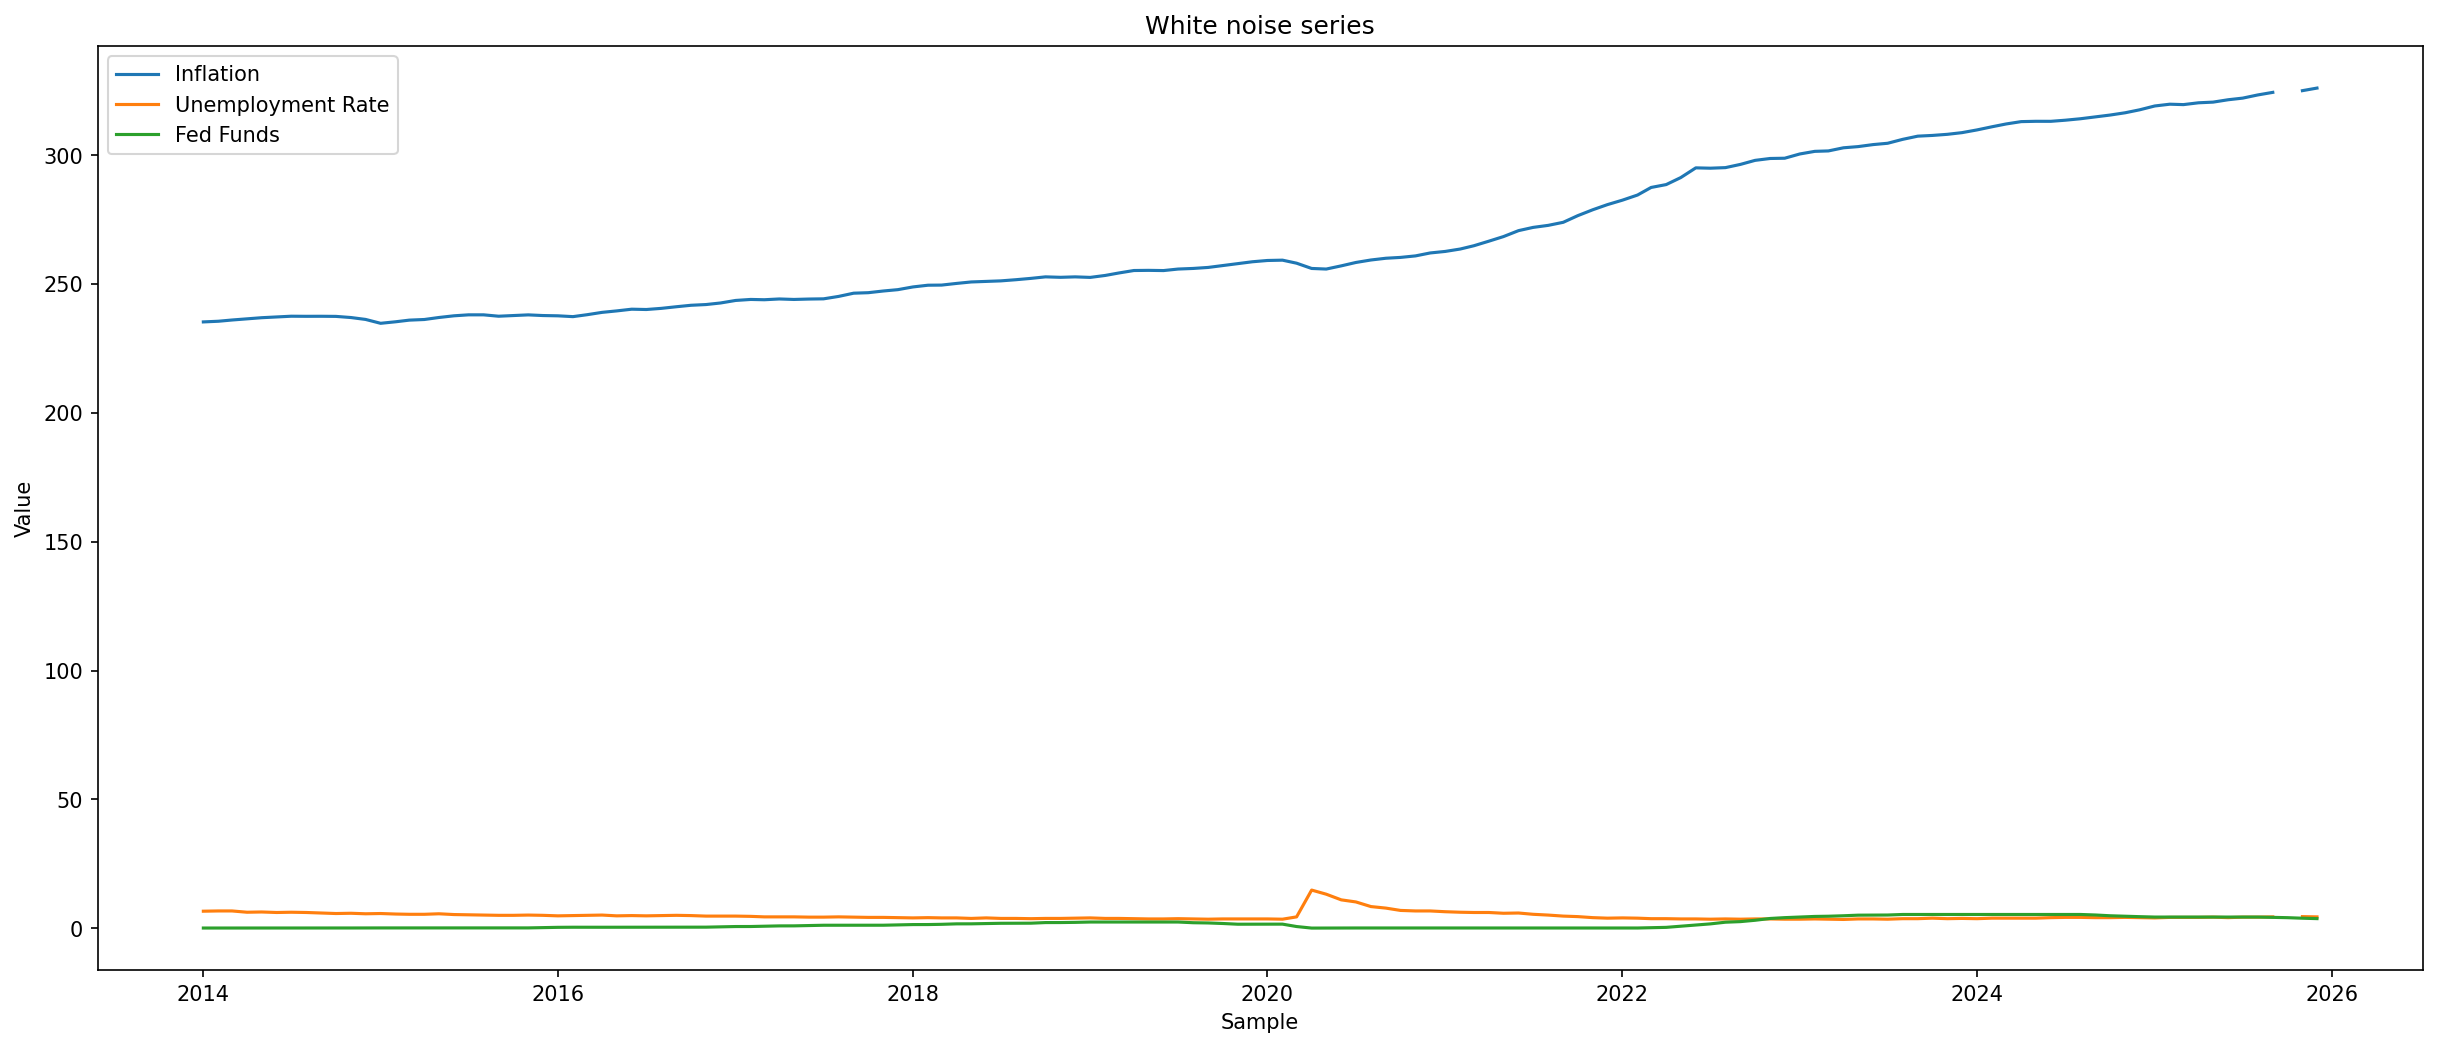

In [ ]:
plt.figure(figsize=(20, 8), dpi=150)

# plot the two white noise series
plt.plot(cpi_m, label='Inflation')
plt.plot(unrate_m, label='Unemployment Rate')
plt.plot(fedfunds_m, label='Fed Funds')

# add legend and axis labels
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('White noise series')

# show the plot
plt.show()

In [ ]:
cpi_diff = cpi_m.diff()
unrate_diff = unrate_m.diff()
fedfunds_diff = fedfunds_m.diff()

In [ ]:
df = pd.concat(
    [differenced, cpi_diff, unrate_diff, fedfunds_diff],
    axis=1)

df.columns = ['AAPL_Price', 'CPI', 'Unemployment', 'FedFunds']
df = df.dropna()


In [ ]:
print(df.shape)
print(df.head())

(141, 4)
            AAPL_Price    CPI  Unemployment  FedFunds
2014-02-01      -0.125  0.259           0.1      0.00
2014-03-01       0.015  0.481           0.0      0.01
2014-04-01       0.050  0.440          -0.5      0.01
2014-05-01       2.140  0.450           0.1      0.00
2014-06-01       1.460  0.313          -0.2      0.01


In [ ]:
# Calculate the correlation between the differenced time series
corr_diff_1 = np.corrcoef(df['AAPL_Price'], df['CPI'])[0, 1]
print(f"The correlation between AAPL and Inflation is {corr_diff_1}.")

The correlation between AAPL and Inflation is -0.048471069449387554.


In [ ]:
# Calculate the correlation between the differenced time series
corr_diff_2 = np.corrcoef(df['AAPL_Price'], df['Unemployment'])[0, 1]
print(f"The correlation between AAPL and unemployment rate is {corr_diff_2}.")

The correlation between AAPL and unemployment rate is -0.03817738338111634.


In [ ]:
# Calculate the correlation between the differenced time series
corr_diff_3 = np.corrcoef(df['AAPL_Price'], df['FedFunds'])[0, 1]
print(f"The correlation between AAPL and Fed Funds is {corr_diff_3}.")

The correlation between AAPL and Fed Funds is -0.007722217354686198.


In [ ]:
correlation_matrix = df.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
              AAPL_Price       CPI  Unemployment  FedFunds
AAPL_Price      1.000000 -0.048471     -0.038177 -0.007722
CPI            -0.048471  1.000000     -0.318241  0.291547
Unemployment   -0.038177 -0.318241      1.000000 -0.314189
FedFunds       -0.007722  0.291547     -0.314189  1.000000


<Axes: >

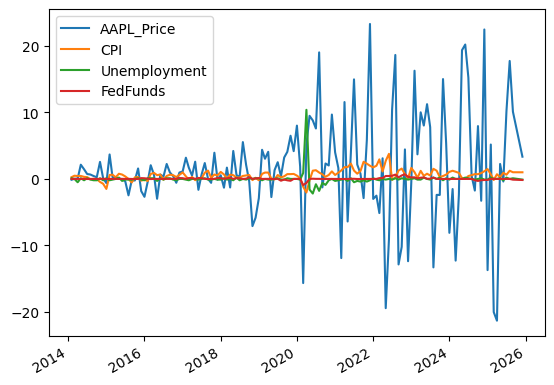

In [ ]:
df.plot()

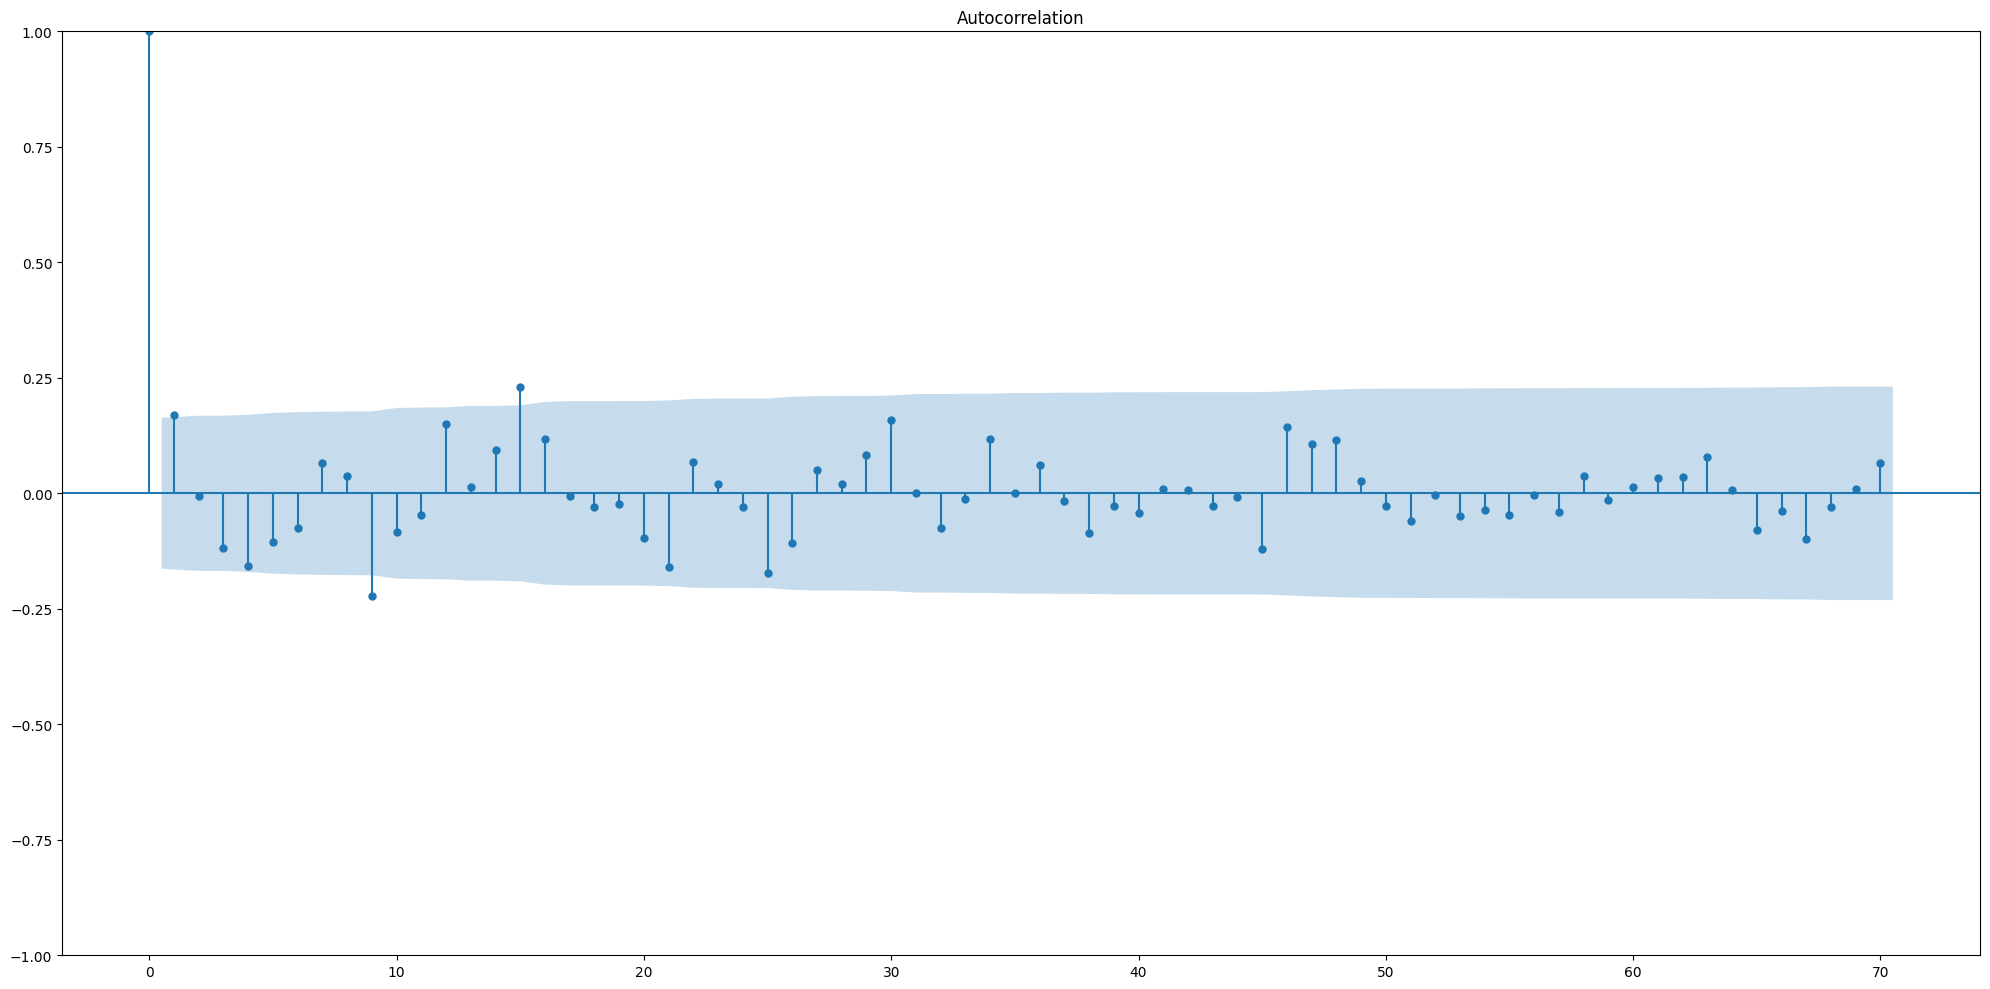

In [ ]:
# Calculate the ACF (via statsmodel)
# Source: https://www.alpharithms.com/autocorrelation-time-series-python-432909/

fig = plot_acf(differenced['AAPL_Spline'].dropna(), lags=70)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

The contemporaneous correlations between AAPL returns and the macroeconomic indicators—inflation (−0.048), unemployment rate (−0.038), and the federal funds rate (−0.008)—are all near zero, indicating almost no linear relationship.

Inflation shows a very slight negative association with AAPL returns, suggesting that higher monthly CPI changes do not meaningfully correspond to stock movements.

The unemployment rate correlation is also weakly negative, implying that short-term fluctuations in labor market conditions have little immediate impact on AAPL’s monthly returns.

The federal funds rate correlation is effectively zero, indicating that monthly changes in policy rates are not directly reflected in AAPL stock performance.

Overall, these results suggest that individual stock returns, such as AAPL’s, are primarily driven by firm-specific factors rather than contemporaneous macroeconomic conditions, though lagged or indirect effects may still exist.

## ETS Models

### train-test data split

In [ ]:
aapl = aapl_df[['AAPL_Spline']]
aapl

,AAPL_Spline
2014-01-01,16.670
2014-02-01,16.545
2014-03-01,16.560
2014-04-01,16.610
2014-05-01,18.750
...,...
2025-09-01,238.690
2025-10-01,256.880
2025-11-01,270.765
2025-12-01,274.110


In [ ]:
from sklearn.model_selection import train_test_split

# Create a test set of 12 data points
test_size = 12

train_data, test_data = train_test_split(aapl, test_size=test_size, random_state=25, shuffle = False)
#shuffle = False is very important to ensure the order of the data

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 133
No. of testing examples: 12


In [ ]:
train_data

,AAPL_Spline
2014-01-01,16.670
2014-02-01,16.545
2014-03-01,16.560
2014-04-01,16.610
2014-05-01,18.750
...,...
2024-09-01,221.520
2024-10-01,229.470
2024-11-01,226.185
2024-12-01,248.670


In [ ]:
test_data

,AAPL_Spline
2025-02-01,240.125
2025-03-01,220.090
2025-04-01,198.760
2025-05-01,201.010
2025-06-01,200.620
2025-07-01,210.830
2025-08-01,228.580
2025-09-01,238.690
2025-10-01,256.880
2025-11-01,270.765


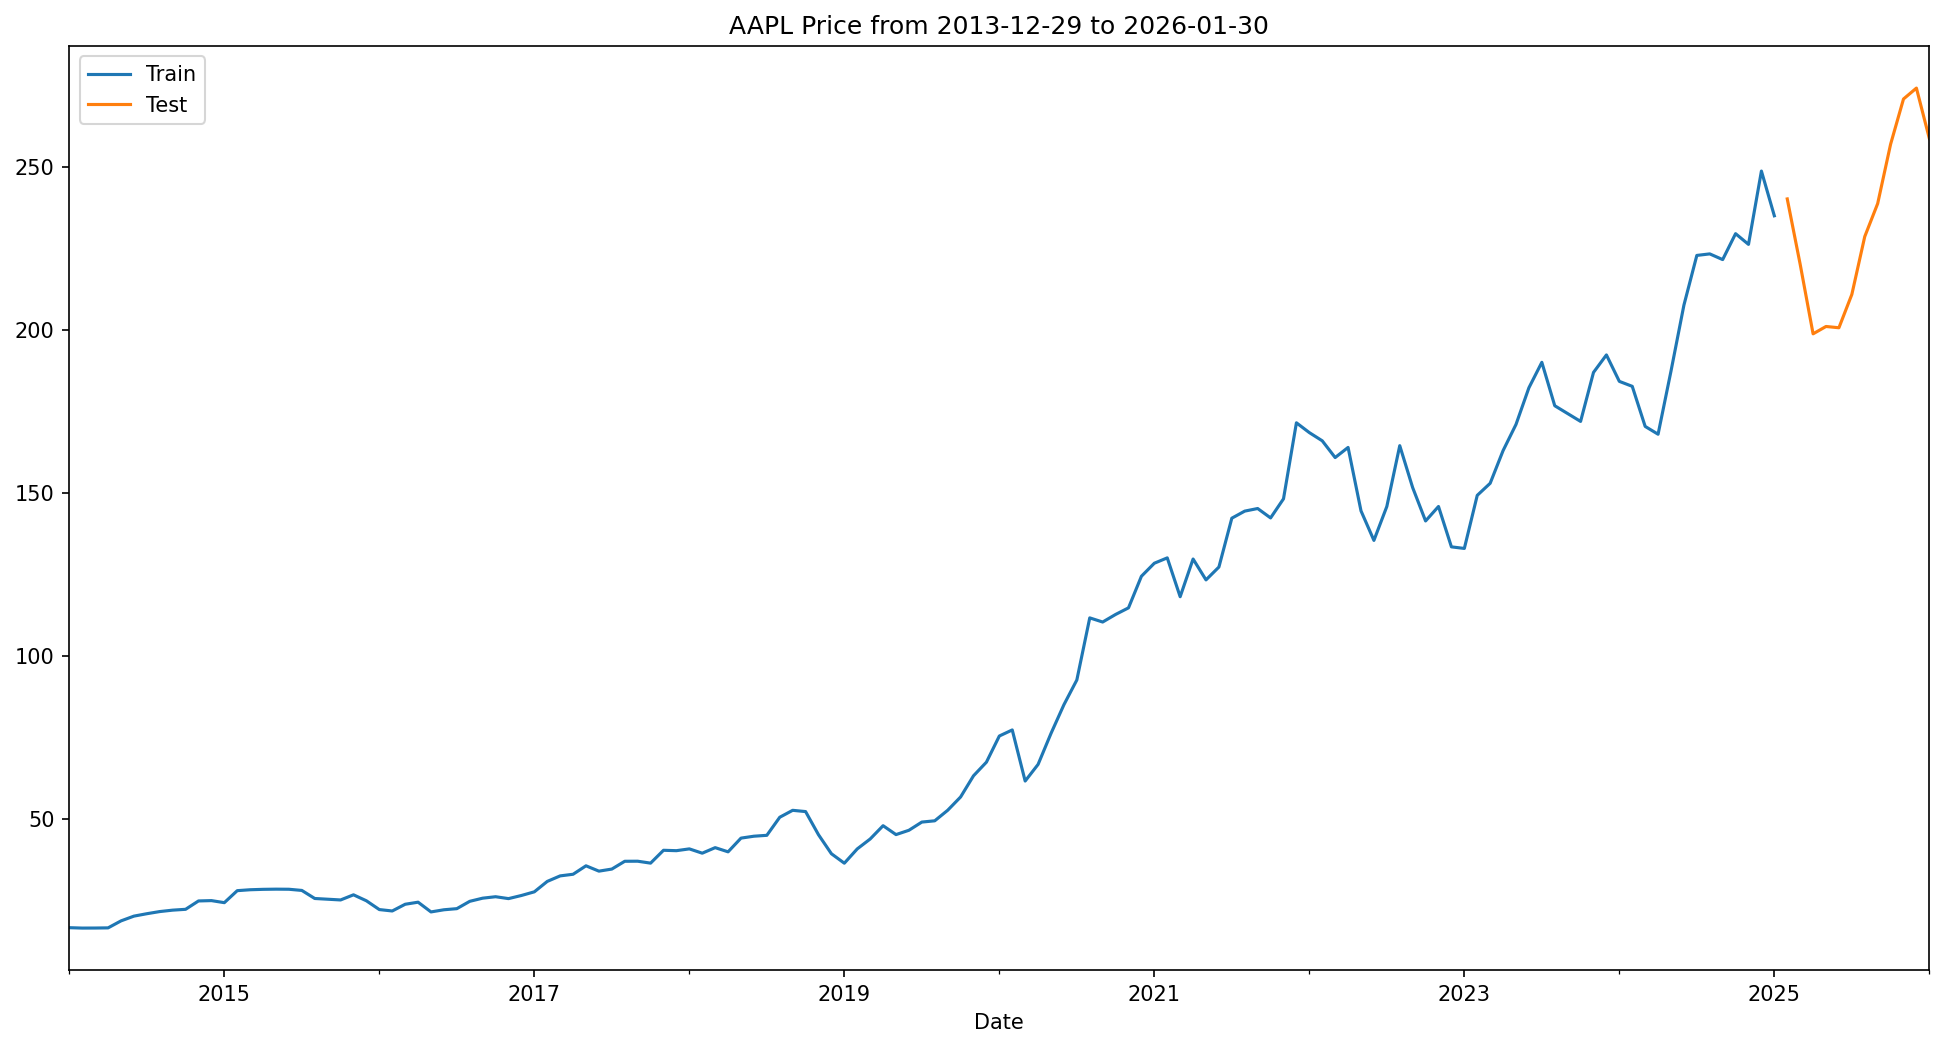

In [ ]:
#Plot train and test data

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
train_data['AAPL_Spline'].plot(label='Train')
test_data['AAPL_Spline'].plot(label='Test')


# adding title to the plot
plt.title('AAPL Price from {} to {}'.format(stock_start_date, stock_end_date))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


#### Simple Exponential Smoothing

In [ ]:
#First Instance
ins1 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.2,optimized=False)
ins_cast1 = ins1.forecast(12).rename('alpha=0.2')

#Second Instance
ins2 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.5,optimized=False)
ins_cast2 = ins2.forecast(12).rename('alpha=0.5')

#Third Instance
ins3 = SimpleExpSmoothing(train_data).fit()
ins_cast3 = ins3.forecast(12).rename('alpha=%s'%ins3.model.params['smoothing_level'])


In [ ]:
ins_cast1

,alpha=0.2
2025-02-01,222.244489
2025-03-01,222.244489
2025-04-01,222.244489
2025-05-01,222.244489
2025-06-01,222.244489
2025-07-01,222.244489
2025-08-01,222.244489
2025-09-01,222.244489
2025-10-01,222.244489
2025-11-01,222.244489


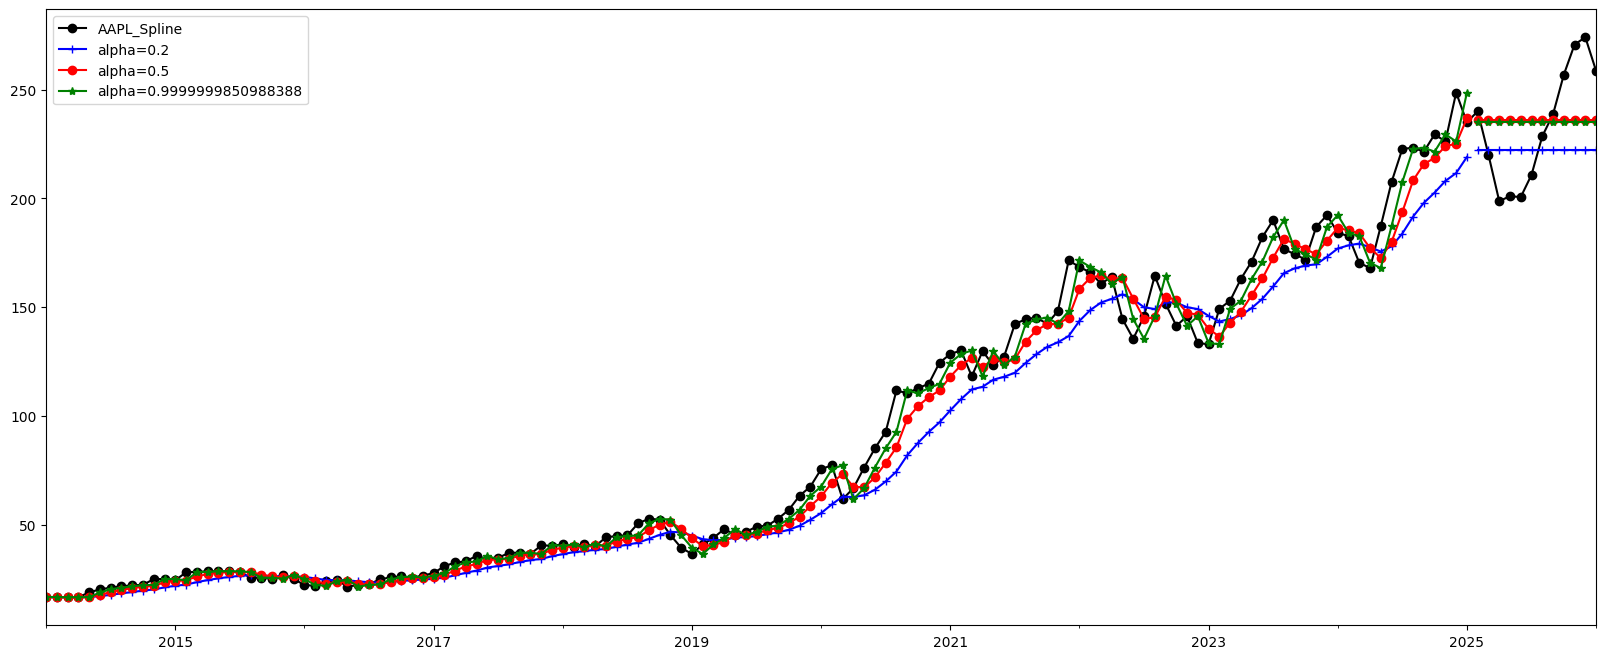

In [ ]:
#After creating model we will visualize the plot
ax = aapl.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for alpha =0.2
ins_cast1.plot(marker='+', ax=ax, color='blue', legend=True)
ins1.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for alpha = 0.5
ins_cast2.plot(marker='o', ax=ax, color='red', legend=True)
ins2.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for alpha=Optimized by statsmodel
ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.show()

#### Double Exponential Smoothing

In [ ]:
double_ets_add = ExponentialSmoothing(train_data, trend = 'add').fit()
double_ets_mul = ExponentialSmoothing(train_data, trend = 'mul').fit()

double_ets_add_pred = double_ets_add.forecast(12)
double_ets_mul_pred = double_ets_mul.forecast(12)


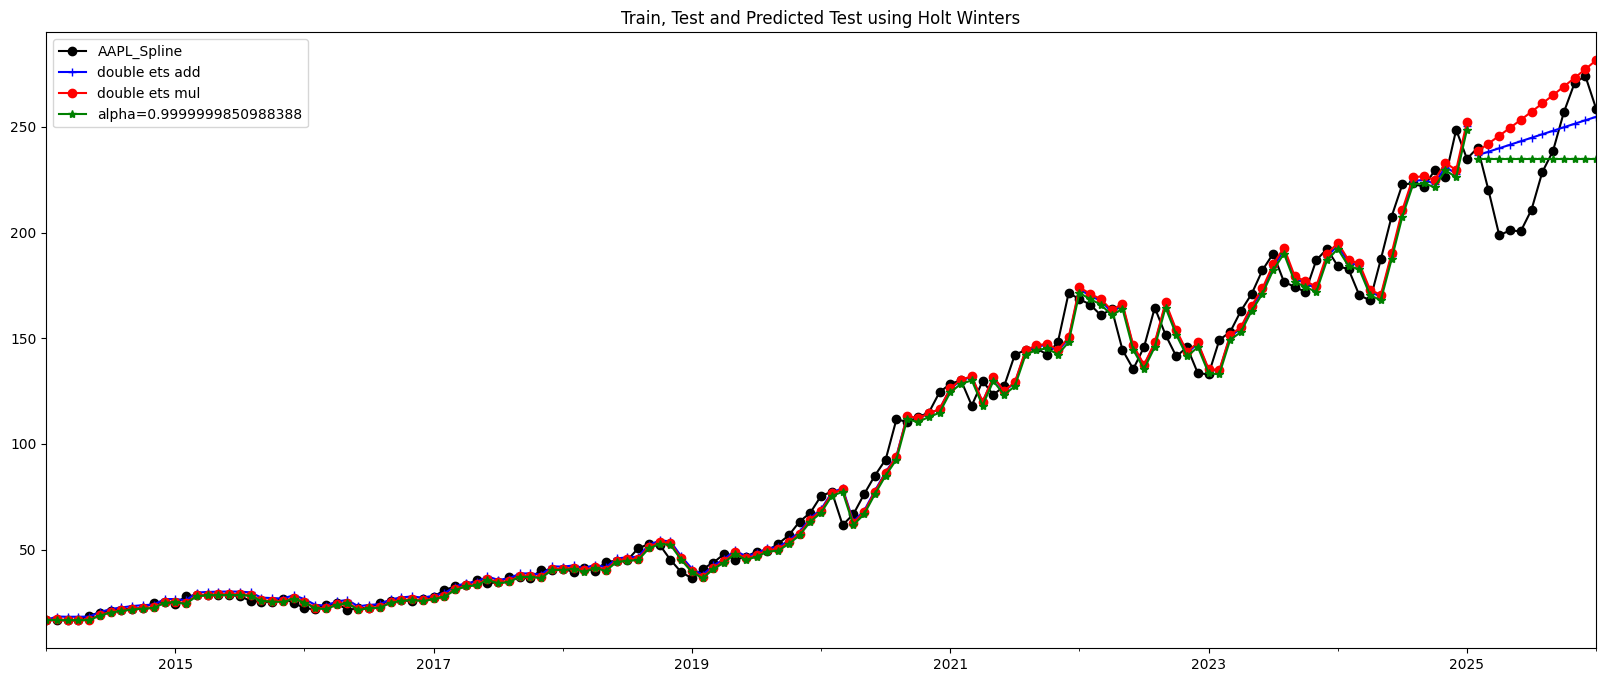

In [ ]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
ax = aapl.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for double ETS additive
double_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'double ets add')
double_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for double ETS multiplicative
double_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'double ets mul')
double_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for simple exponential smooting alpha=Optimized by statsmodel
ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()



#### Third Exponential Smoothing

In [ ]:
# triple ETS - Holt Winter's Seasonal Method
triple_ets_add = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()

triple_ets_add_pred = triple_ets_add.forecast(12)
triple_ets_mul_pred = triple_ets_mul.forecast(12)

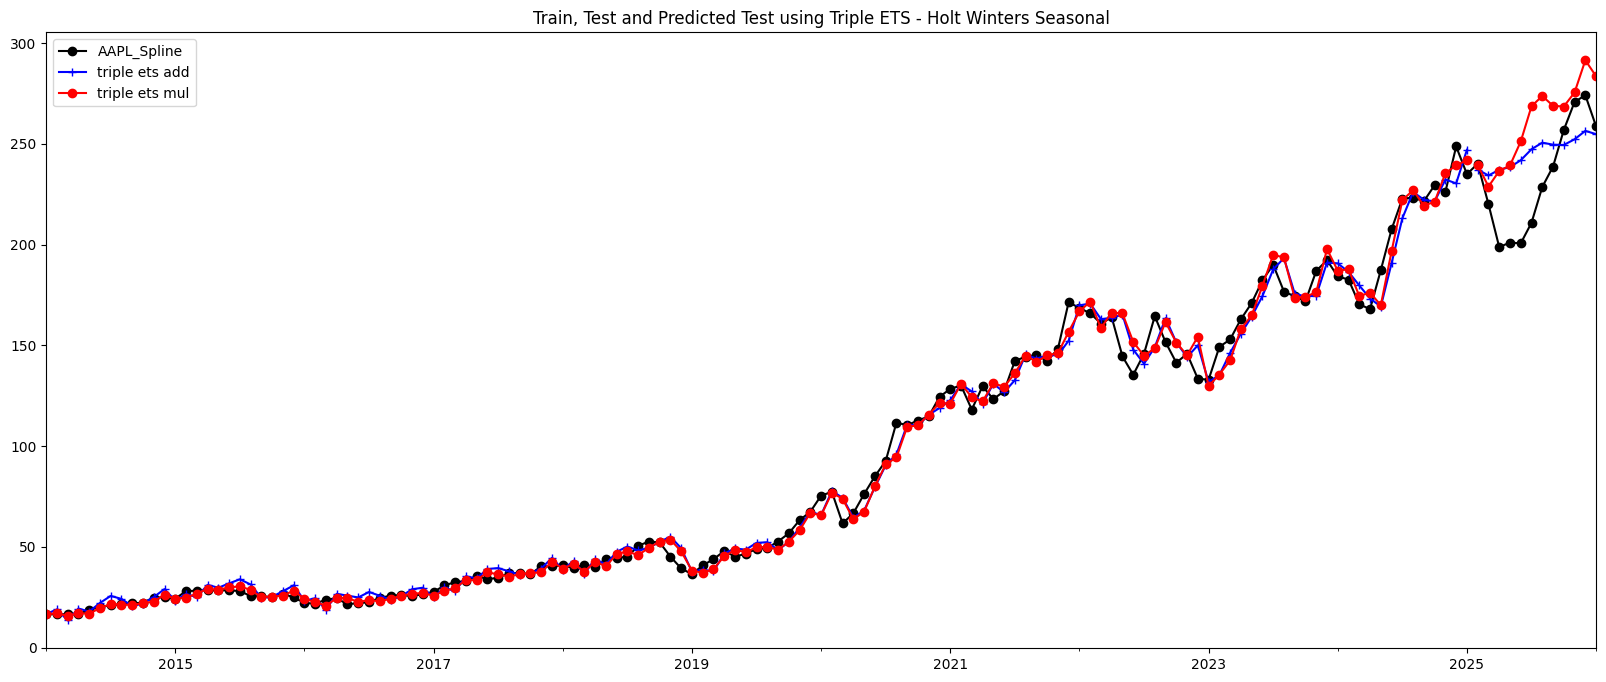

In [ ]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
ax = aapl.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for double ETS additive
triple_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'triple ets add')
triple_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for double ETS multiplicative
triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'triple ets mul')
triple_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for simple exponential smooting alpha=Optimized by statsmodel
#ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
#ins3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.title('Train, Test and Predicted Test using Triple ETS - Holt Winters Seasonal')
plt.show()

## Visualize Forecast Errors

**Calculate Residuals**

In [ ]:
residuals = [test_data.values.flatten()[i]-triple_ets_add_pred.values.flatten()[i] for i in range(len(test_data))]
residuals = pd.DataFrame(residuals)
residuals

,0
0,2.889770
1,-14.187490
2,-38.379758
3,-37.431145
4,-41.231994
5,-36.489889
6,-21.993873
7,-10.889774
8,7.452925
9,18.521228


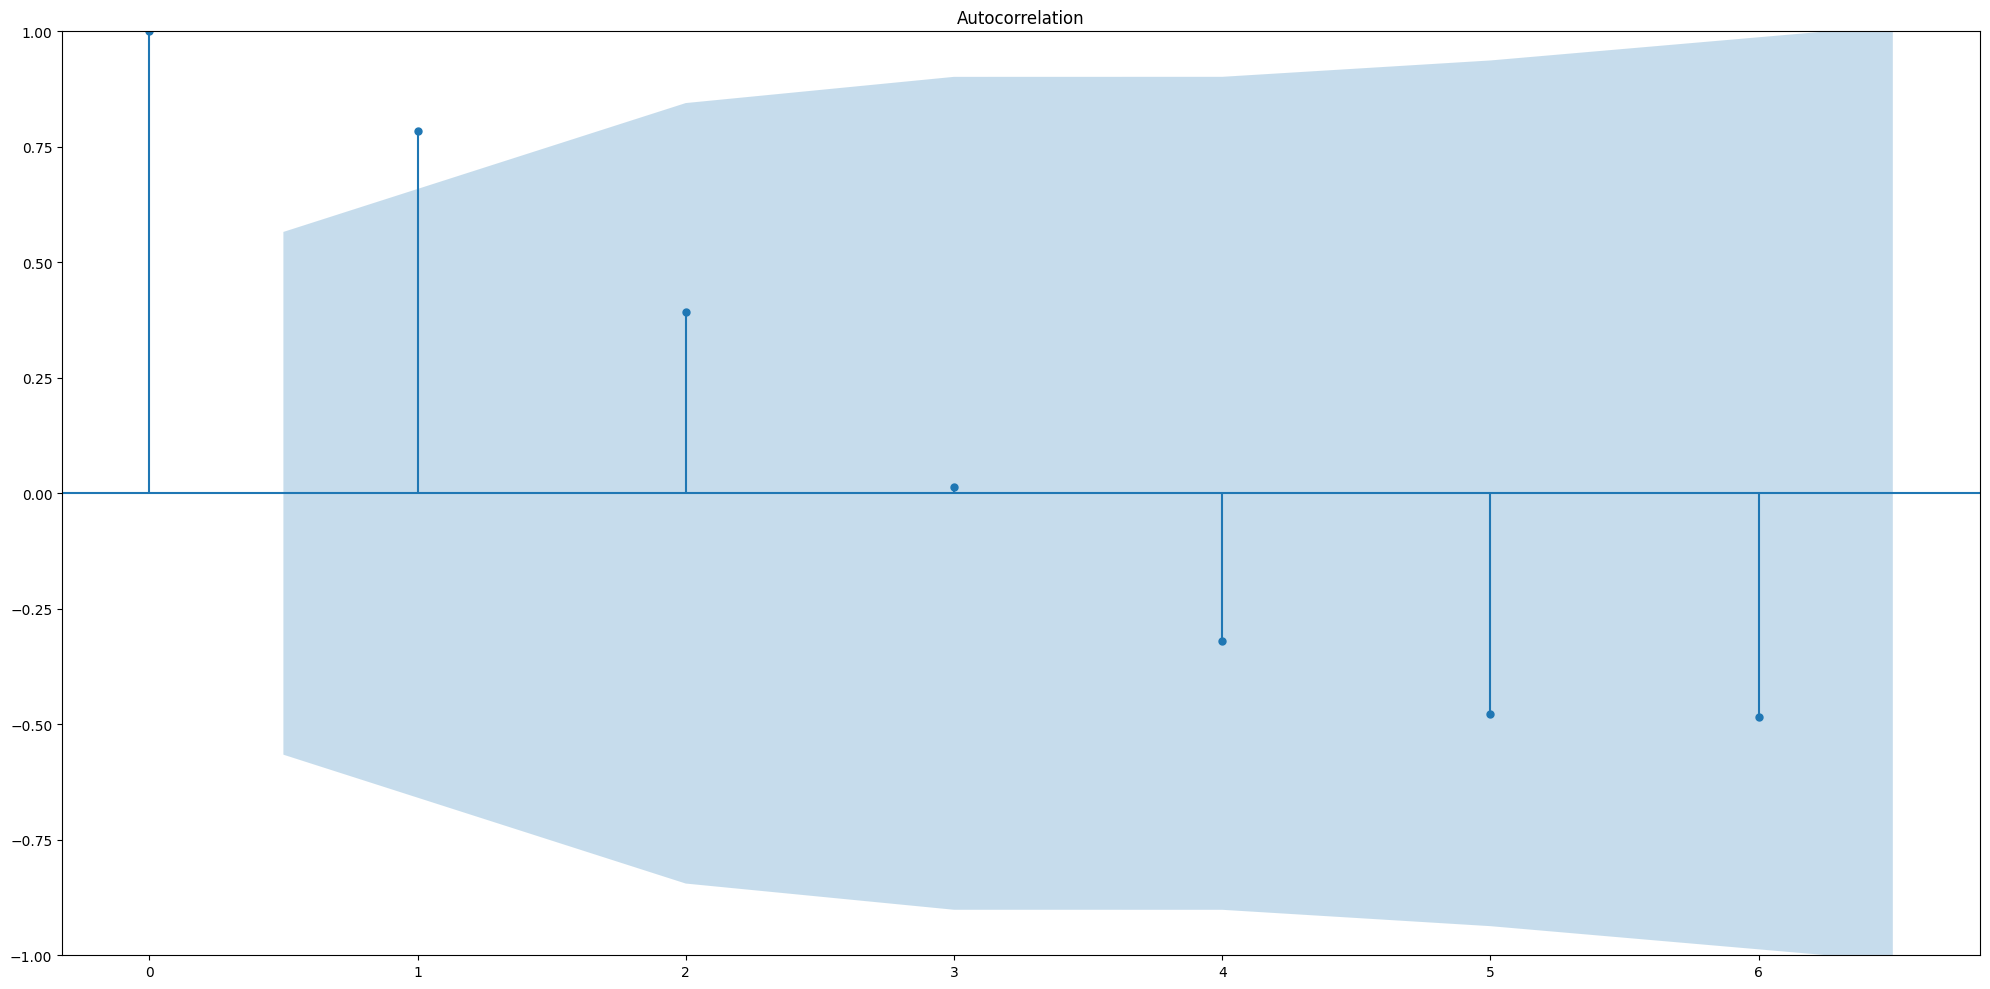

In [ ]:
fig = plot_acf(residuals)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

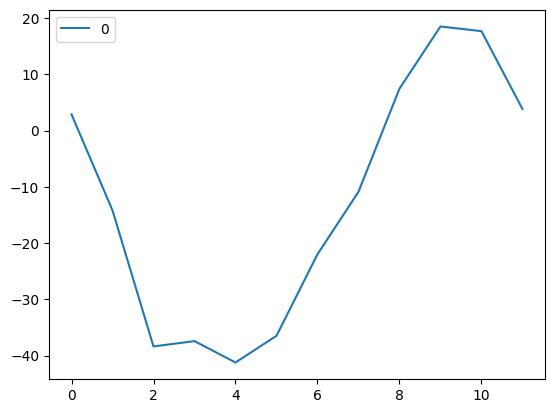

In [ ]:
# plot residuals
residuals.plot()
plt.show()

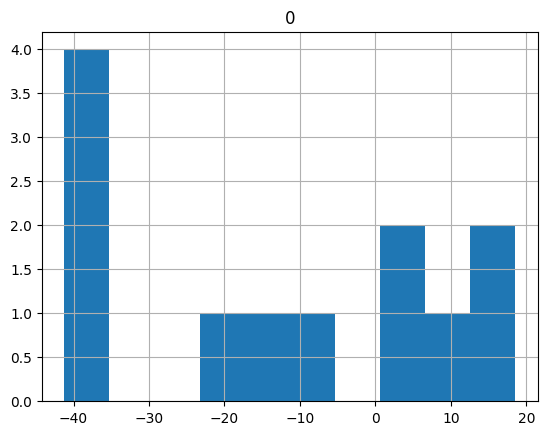

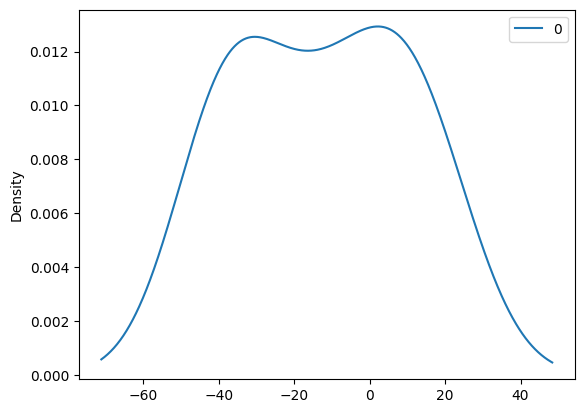

In [ ]:
# histogram plot
residuals.hist()
plt.show()
# density plot
residuals.plot(kind='kde')
plt.show()

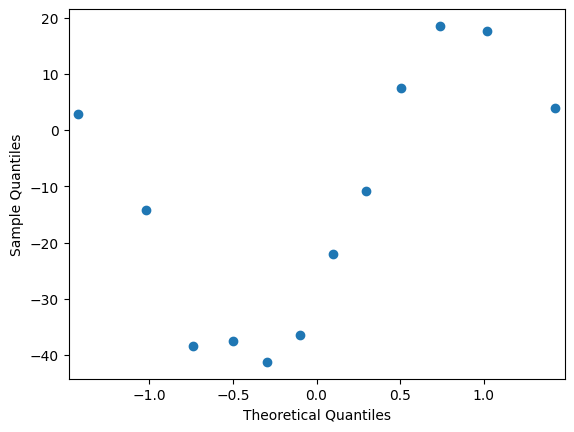

In [ ]:
qqplot(residuals)
plt.show()

### Metrics


In addition to RMSE, MAE, and MAPE, this analysis uses SMAPE and MASE to further evaluate forecast accuracy. SMAPE reduces the scale sensitivity and asymmetry issues present in MAPE, while MASE compares forecast performance against a naïve benchmark, making it particularly suitable for time series evaluation.

In [ ]:
def smape(actuals, predictions):
    return np.mean(
        2 * np.abs(predictions - actuals) /
        (np.abs(actuals) + np.abs(predictions))
    ) * 100


def mase(actuals, predictions, train_series):
    naive_error = np.mean(np.abs(train_series[1:] - train_series[:-1]))
    return np.mean(np.abs(actuals - predictions)) / naive_error


In [ ]:
#define metrics dataframe which will be used below for storing results
metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE'])

def metrics_cal(actuals, predictions, model, train_series):

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    smape_val = smape(actuals, predictions)
    mase_val = mase(actuals, predictions, train_series)

    df = pd.DataFrame({
        'Model': [model],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape],
        'sMAPE': [smape_val],
        'MASE': [mase_val]
    })

    global metrics_dataframe
    metrics_dataframe = pd.concat([metrics_dataframe, df], ignore_index=True)

    return metrics_dataframe


In [ ]:
metrics_dataframe = pd.DataFrame()

metrics_dataframe = metrics_cal(
    test_data.values.flatten(),
    ins_cast1.values.flatten(),
    'Simple 0.2',
    train_data.values.flatten()
)

metrics_dataframe = metrics_cal(
    test_data.values.flatten(),
    ins_cast2.values.flatten(),
    'Simple 0.5',
    train_data.values.flatten()
)

metrics_dataframe = metrics_cal(
    test_data.values.flatten(),
    ins_cast3.values.flatten(),
    'Simple 1',
    train_data.values.flatten()
)

metrics_dataframe = metrics_cal(
    test_data.values.flatten(),
    double_ets_add_pred.values.flatten(),
    'Double Add',
    train_data.values.flatten()
)

metrics_dataframe = metrics_cal(
    test_data.values.flatten(),
    double_ets_mul_pred.values.flatten(),
    'Double Mul',
    train_data.values.flatten()
)

metrics_dataframe = metrics_cal(
    test_data.values.flatten(),
    triple_ets_add_pred.values.flatten(),
    'Triple Add',
    train_data.values.flatten()
)

metrics_dataframe = metrics_cal(
    test_data.values.flatten(),
    triple_ets_mul_pred.values.flatten(),
    'Triple Mul',
    train_data.values.flatten()
)


In [ ]:
triple_ets_add_pred.values.flatten()

array([237.23523007, 234.2774895 , 237.13975775, 238.44114465,
       241.85199359, 247.31988946, 250.57387289, 249.57977353,
       249.42707531, 252.24377173, 256.42075451, 254.79648989])

In [ ]:
# Create a data frame with all the predictions along with the test data
test_pred_df = test_data.copy()

# Add all predictions
test_pred_df = test_pred_df.assign(triple_ets_mul_pred = triple_ets_mul_pred.values.flatten(),
                                   SimpleExp_1_pred = ins_cast3.values.flatten(),
                                   double_ets_mul_pred = double_ets_mul_pred.values.flatten())

test_pred_df

,AAPL_Spline,triple_ets_mul_pred,SimpleExp_1_pred,double_ets_mul_pred
2025-02-01,240.125,239.513415,234.95,238.518613
2025-03-01,220.090,228.780905,234.95,242.141428
2025-04-01,198.760,236.526989,234.95,245.819270
2025-05-01,201.010,239.255311,234.95,249.552973
2025-06-01,200.620,251.157683,234.95,253.343388
2025-07-01,210.830,268.639813,234.95,257.191374
2025-08-01,228.580,273.730178,234.95,261.097806
2025-09-01,238.690,268.856948,234.95,265.063573
2025-10-01,256.880,268.506351,234.95,269.089575
2025-11-01,270.765,275.471281,234.95,273.176727


In [ ]:
# Create an average prediction from the three and check it's metrics
test_pred_df['Average_Predictions'] = (test_pred_df['SimpleExp_1_pred']+test_pred_df['triple_ets_mul_pred']+test_pred_df['double_ets_mul_pred'])/3
test_pred_df

,AAPL_Spline,triple_ets_mul_pred,SimpleExp_1_pred,double_ets_mul_pred,Average_Predictions
2025-02-01,240.125,239.513415,234.95,238.518613,237.660676
2025-03-01,220.090,228.780905,234.95,242.141428,235.290778
2025-04-01,198.760,236.526989,234.95,245.819270,239.098753
2025-05-01,201.010,239.255311,234.95,249.552973,241.252762
2025-06-01,200.620,251.157683,234.95,253.343388,246.483690
2025-07-01,210.830,268.639813,234.95,257.191374,253.593729
2025-08-01,228.580,273.730178,234.95,261.097806,256.592662
2025-09-01,238.690,268.856948,234.95,265.063573,256.290174
2025-10-01,256.880,268.506351,234.95,269.089575,257.515309
2025-11-01,270.765,275.471281,234.95,273.176727,261.199336


In [ ]:
metrics_dataframe = metrics_cal(
    test_data.iloc[:,0].astype(float).values,
    test_pred_df['Average_Predictions'].astype(float).values,
    'Average',
    train_data.iloc[:,0].astype(float).values
)

metrics_dataframe.sort_values(by='MAE')

,Model,RMSE,MAE,MAPE,sMAPE,MASE
5,Triple Add,24.906587,20.918383,9.609478,9.042311,4.313338
7,Average,26.933582,21.408129,10.013348,9.258573,4.414323
3,Double Add,25.726236,21.552576,9.901231,9.308826,4.444108
1,Simple 0.5,26.511412,23.278333,10.219039,9.995930,4.799956
2,Simple 1,26.431415,23.278333,10.176895,9.996249,4.799956
0,Simple 0.2,28.585050,24.334252,10.088501,10.460709,5.017685
4,Double Mul,32.185131,26.495972,12.310129,11.240702,5.463428
6,Triple Mul,32.768386,27.291964,12.452595,11.387786,5.627561


Best performing model is Triple Add with the lowest RMSE (24.91), MAE (20.92), MAPE (9.61%), sMAPE (9.04%), and MASE (4.31), making it the most accurate among all models. The Average of the three ETS-based predictions performs slightly worse than Triple Add alone (RMSE 26.93 vs 24.91) but better than most single simple or double models. This shows some benefit from ensembling, but not enough to outperform the best triple additive ETS. Simple 0.5 and Simple 1 have similar MAE (23.28) and sMAPE (9.99%), which are worse than Triple Add and the Average. Both Double Mul and Triple Mul perform substantially worse than additive ETS (RMSE > 32, sMAPE > 11%). This suggests that multiplicative seasonality or trend may not fit the series well.